Mehran Farajinegarestan  
mehran.farajinegarestan@studenti.unipd.it  
June 27, 2023

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
from tqdm.notebook import tqdm
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torch.nn.functional as functional
import torchvision as tv
import seaborn as sns
from skimage.util import random_noise

from DBN import DBN

In [ ]:
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

CUDA is available: True


In [ ]:
def get_data():
    transformer = tv.transforms.Compose(
        [
            tv.transforms.ToTensor(),
        ]
    )
    train = tv.datasets.EMNIST(
        root = 'data/',
        train = True,
        split = 'letters',
        download = True,
        transform = transformer)

    test = tv.datasets.EMNIST(
        root = 'data/',
        train = False,
        download = True,
        split = 'letters',
        transform = transformer,)

    data_train, labels_train, data_test, labels_test = preprocessing_data(train, test)

    data_train = data_train.to(device)
    labels_train = labels_train.to(device)
    data_test = data_test.to(device)
    labels_test = labels_test.to(device)

    return data_train, labels_train, data_test, labels_test

def preprocessing_data(train, test):
    train.data = (train.data.type(torch.FloatTensor)/255)
    test.data = (test.data.type(torch.FloatTensor)/255)

    labels_to_keep = [1,2,3,4,5,6,7,8,9,10]
    idxs = [i for i in range(len(train.targets)) if train.targets[i] in labels_to_keep]
    data_train, labels_train =  train.data[idxs], train.targets[idxs]
    idxs = [i for i in range(len(test.targets)) if test.targets[i] in labels_to_keep]
    data_test, labels_test =  test.data[idxs], test.targets[idxs]

    labels_train = labels_train - 1
    labels_test = labels_test - 1

    return data_train, labels_train, data_test, labels_test

In [ ]:
def visualize_label(label, data, labels, figsize = (5, 5), n_subplots = 9):

    n_rows_cols = int(math.sqrt(n_subplots))
    _, axes = plt.subplots(
        n_rows_cols,
        n_rows_cols,
        sharex = True,
        sharey = True,
        figsize = figsize
    )
    data_filt = data[labels == label].cpu()

    counter = 0
    for i in range(n_subplots):
        col = i % n_rows_cols
        row = i // n_rows_cols
        image = data_filt[counter]
        axes[row, col].imshow(image, cmap = 'binary')
        counter += 1

In [ ]:
def print_data_shape():
    print('data_train.shape:', data_train.shape)
    print('labels_train.shape:', labels_train.shape)
    print('data_test.shape:', data_test.shape)
    print('labels_test.shape:', labels_test.shape)

In [ ]:
def plot_sample_data(data, num_subplots = 100):
  n_rows_cols = int(math.sqrt(num_subplots))
  indices = torch.randint(0,len(data), size= (100,))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(data[indices[i],:].reshape((28,28)).cpu(), cmap=plt.cm.gray)

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [ ]:
def train_dbn_static(model, num_epochs = 50, batch_size = 125):
        model.train_static(
            data_train,
            labels_train,
            num_epochs,
            batch_size)

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def plot_layer_receptive_fields(weights, num_subplots = 25):
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

In [ ]:
def get_learned_weights(model):
    learned_weights_layer_1 = get_weights(model, layer=0)
    learned_weights_layer_2 = get_weights(model, layer=1)
    learned_weights_layer_3 = get_weights(model, layer=2)

    learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
    learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
    learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

    learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)
    learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)
    learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)
    learned_weights_12_product = apply_threshold(learned_weights_12_product, 0.1)
    learned_weights_12_product = apply_min_max_scaler(learned_weights_12_product)
    learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
    learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

    return learned_weights_layer_1, learned_weights_12_product, learned_weights_23_product


In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

In [ ]:
def get_all_layer_repr(data):
    hidden_repr_layer_1 = get_kth_layer_repr(data, 0, device)
    hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
    hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)
    return hidden_repr_layer_1, hidden_repr_layer_2, hidden_repr_layer_3

In [ ]:
def get_mask(label):
  labels = labels_train.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)
    for label in range(10)])

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  plt.xlabel('Number of Label', fontsize = 10)
  plt.ylabel('Hierarchy level', fontsize = 10)
  ax.set_title(title)

In [ ]:
def plot_pair(data, labels, label1, label2, n_try = 2):
    idx1 = (labels == label1).nonzero(as_tuple = False)[n_try]
    idx2 = (labels == label2).nonzero(as_tuple = False)[n_try]

    _, ax = plt.subplots(1, 2)
    ax[0].imshow(data[idx1].reshape(28, 28).cpu())
    ax[1].imshow(data[idx2].reshape(28, 28).cpu())

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [ ]:
def get_linear_models(model):
    layer_size = model.rbm_layers[0].W.shape[1]
    linear1 = LinearModel(layer_size).to(device)
    layer_size = model.rbm_layers[1].W.shape[1]
    linear2 = LinearModel(layer_size).to(device)
    layer_size = model.rbm_layers[2].W.shape[1]
    linear3 = LinearModel(layer_size).to(device)
    return linear1, linear2, linear3

In [ ]:
def train(model, hidden_reprs, epochs = 1500):
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()


  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(hidden_reprs).squeeze()
    targets = labels_train.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
def inject_noise_gaussian(data, noise_level):

  random_gaussian_tensor = torch.randn(data.shape, device = device)*noise_level
  return data + random_gaussian_tensor

In [ ]:
def inject_noise_sp(data, noise_level):
  noised_data = torch.tensor(random_noise(data.cpu(), mode='s&p', amount = noise_level))
  return noised_data

In [ ]:
def get_accuracy_values_at_noise_level(noise_func,noise_level):

  mnist_test_with_noise = noise_func(data_test, noise_level).to(device)

  hidden_repr_layer_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, labels_test)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, labels_test)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, labels_test)

  predictions_ffnn_noisy = ffnn(mnist_test_with_noise.reshape((-1, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, labels_test)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
def plot_noise_robustness_curves(noise_type,noise_levels):

  accuracies = {
  'accuracy_values_first_hidden' : [],
  'accuracy_values_second_hidden' : [],
  'accuracy_values_third_hidden' : [],
  'accuracy_values_ffnn' : []
  }
  if noise_type == 'gaussian':
    noise_func = inject_noise_gaussian
  else:
    noise_func = inject_noise_sp

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_func, noise_level)
    accuracies['accuracy_values_first_hidden'].append(acc[0])
    accuracies['accuracy_values_second_hidden'].append(acc[1])
    accuracies['accuracy_values_third_hidden'].append(acc[2])
    accuracies['accuracy_values_ffnn'].append(acc[3])

  fig, ax = plt.subplots()
  for k, v in accuracies.items():
    ax.plot(
        v,
        marker = 'o',
        markerfacecolor = 'black',
        markersize = 4
    )
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.grid()
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])
  if noise_type == 'gaussian':
    ax.set_title("Noise robustness for FFNN and linear\nread-outs (Gaussian noise)")
  else:
    ax.set_title("Noise robustness for FFNN and linear\nread-outs (Salt & Pepper noise)")

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
def attack_demo(attacked_model,index=100, epsilon= 0.2):
    test_image = data_test[index].reshape(1, 784)
    test_image_label = labels_test[index].unsqueeze(0)

    test_image.requires_grad_()
    clean_output = attacked_model(test_image)
    clean_pred = torch.argmax(clean_output)


    loss_value = torch.nn.functional.cross_entropy(clean_output, test_image_label)
    attacked_model.zero_grad()
    loss_value.backward()
    image_grad = test_image.grad.data
    perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
    test_image_np = test_image.reshape(28,28).detach().to('cpu').numpy()
    perturbed_image_np = perturbed_image.detach().to('cpu').numpy().reshape(28,28)
    attacked_output = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
    attacked_output = torch.argmax(attacked_output)

    print(f"The prediction of the model for this clean sample is {clean_pred}.")
    print(f"The prediction of the model for the perturbed sample is {attacked_output}.")

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(test_image_np)
    axs[0].set_title(f'Sample image before\nTrue label: {test_image_label[0]}\nPredicted label: {clean_pred}', fontsize=15)
    axs[1].imshow(perturbed_image_np)
    axs[1].set_title(f'Sample image after attack\nTrue label: {test_image_label[0]}\nPredicted label: {attacked_output}', fontsize=15)

    plt.tight_layout()
    plt.show()


In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    
    for data, target in (test_loader):
        data = data.to(device)
        target  = target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True
        output = model.forward(data)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        output = model(perturbed_data)


        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
def get_data_loader():
    data = [[d, l] for d, l in zip(data_test, labels_test)]
    test_loader = torch.utils.data.DataLoader(data, shuffle = True, batch_size = 1)
    return test_loader

In [ ]:
def test_epsilon_values_effect(model, epsilons, n_steps):
  accuracies = list()

  for eps in epsilons:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

## Getting Data

In [ ]:
data_train, labels_train, data_test, labels_test = get_data()

In [ ]:
print_data_shape()

data_train.shape: torch.Size([48000, 28, 28])
labels_train.shape: torch.Size([48000])
data_test.shape: torch.Size([8000, 28, 28])
labels_test.shape: torch.Size([8000])


## Data Visualization

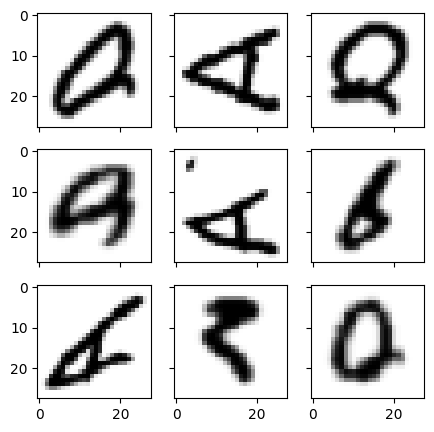

In [ ]:
visualize_label(0,data_train, labels_train)

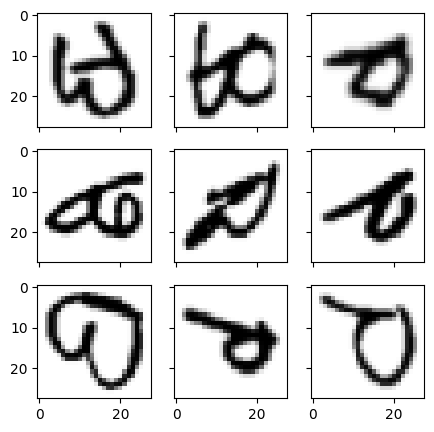

In [ ]:
visualize_label(1, data_train, labels_train)

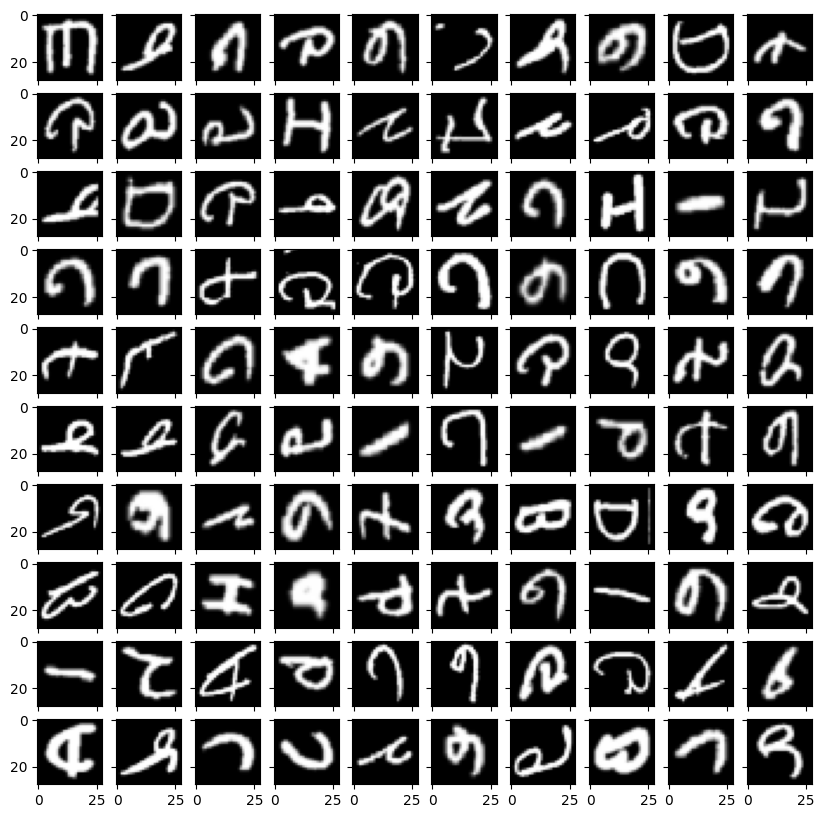

In [ ]:
plot_sample_data(data_train)

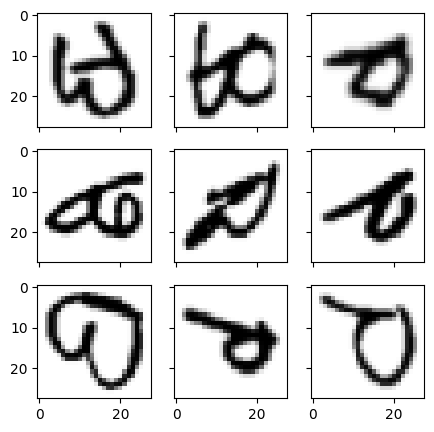

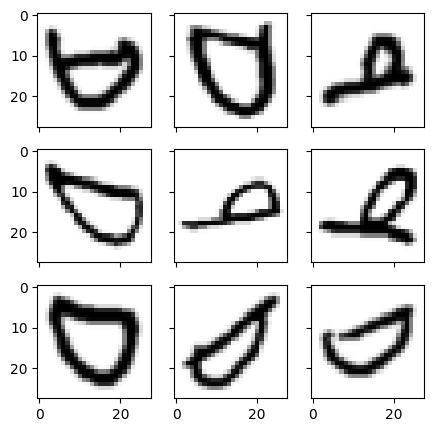

In [ ]:
visualize_label(1, data_train, labels_train)
visualize_label(3, data_train, labels_train)

## Class distribution

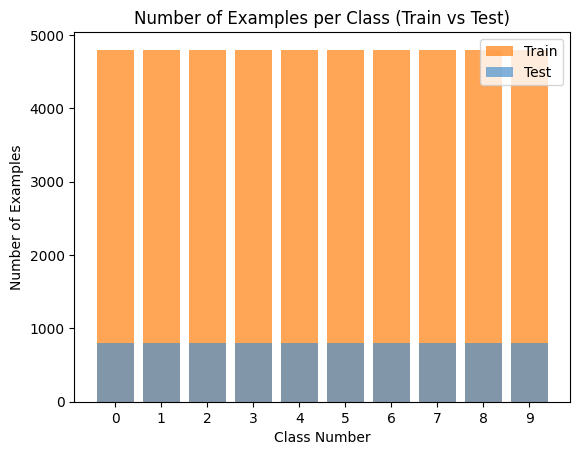

In [ ]:
train_counts = np.bincount(labels_train.cpu(), minlength=10)
test_counts = np.bincount(labels_test.cpu(), minlength=10)
x = np.arange(10)

train_color = '#ff7f0e'
test_color = '#4C91CD'
plt.bar(x, train_counts, label='Train', alpha=0.7, color=train_color)
plt.bar(x, test_counts, label='Test', alpha=0.7, color=test_color)

plt.xlabel('Class Number')
plt.ylabel('Number of Examples')
plt.title('Number of Examples per Class (Train vs Test)')
plt.xticks(x)
plt.legend()
plt.show()

## Defining and Trainin the Model

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [ ]:
train_dbn_static(dbn_emnist, num_epochs=50, batch_size= 128)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.4195     |0.0478       |339.6009   |4.5226     |
|20    |1.3304     |0.0441       |318.4720   |4.3638     |
|30    |1.3001     |0.0435       |310.0023   |4.4852     |
|40    |1.2841     |0.0427       |305.1578   |4.7435     |
|50    |1.2775     |0.0416       |304.2110   |4.9259     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7219     |0.0469       |226.6461   |3.1812     |
|20    |1.5940     |0.0424       |215.2642   |2.9073     |
|30    |1.5687     |0.0425       |214.0854   |2.9690     |
|40    |1.5590     |0.0429       |212.6420   |2.7446     |
|50    |1.5556     |0.0405       |212.2285   |2.9953     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2492     |0.0358       |271.2406   |3.7897     |
|20    |1.0991     |0.0300       |249.5387   |3.336

In [ ]:
train_dbn_static(dbn_emnist, num_epochs=50, batch_size= 128)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.4167     |0.0472       |338.5223   |5.8699     |
|20    |1.3239     |0.0450       |316.5042   |5.2478     |
|30    |1.2989     |0.0431       |310.8998   |4.9830     |
|40    |1.2868     |0.0425       |307.2712   |4.0511     |
|50    |1.2781     |0.0389       |305.5361   |3.9996     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7170     |0.0472       |225.2942   |3.1800     |
|20    |1.5769     |0.0422       |211.6993   |3.3127     |
|30    |1.5521     |0.0426       |209.5951   |2.9330     |
|40    |1.5417     |0.0412       |208.6602   |2.4694     |
|50    |1.5384     |0.0423       |208.2809   |2.8802     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2493     |0.0344       |266.6103   |3.8329     |
|20    |1.1004     |0.0323       |245.8402   |3.675

In [ ]:
torch.save(dbn_emnist, 'dbn_emnist.pt')

In [ ]:
dbn_emnist = torch.load('dbn_emnist.pt')
dbn_emnist.eval()

DBN()

## Visualizing receptive fields

### Analysis of the receptive fields
- In this section receptive fields are visualized. We can see that different internal weights (representations) focus more on some particular regions (white areas demonstrate stronger connections)
- At the deeper levels, receptive fields become more focused on particular regions of the images

In [ ]:
learned_weights_layer_1, learned_weights_12_product, learned_weights_23_product = get_learned_weights(dbn_emnist)

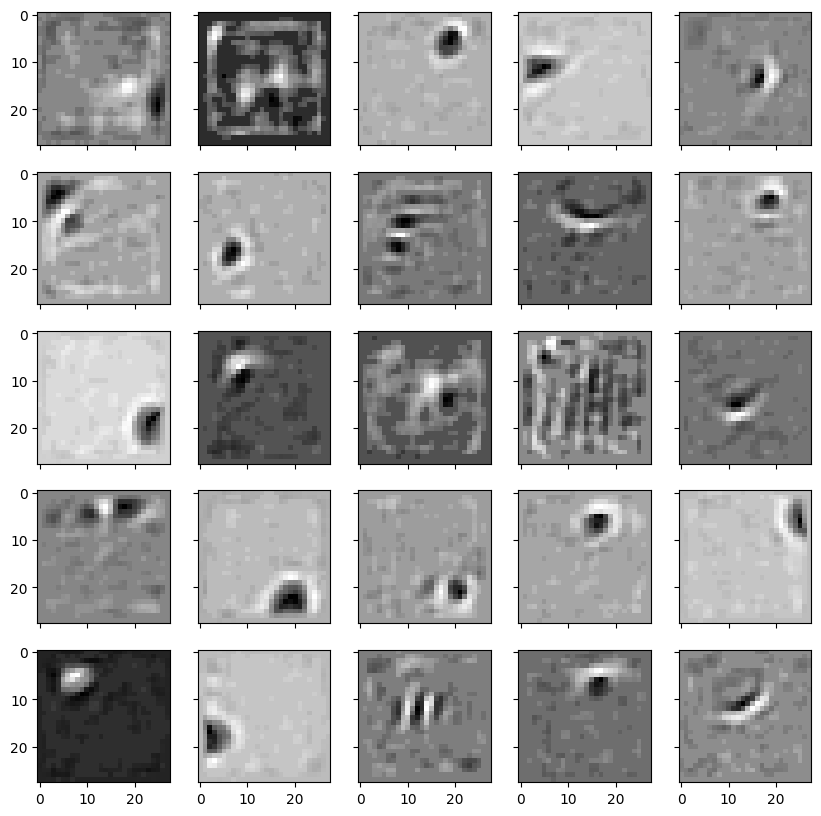

In [ ]:
plot_layer_receptive_fields(learned_weights_layer_1.T)

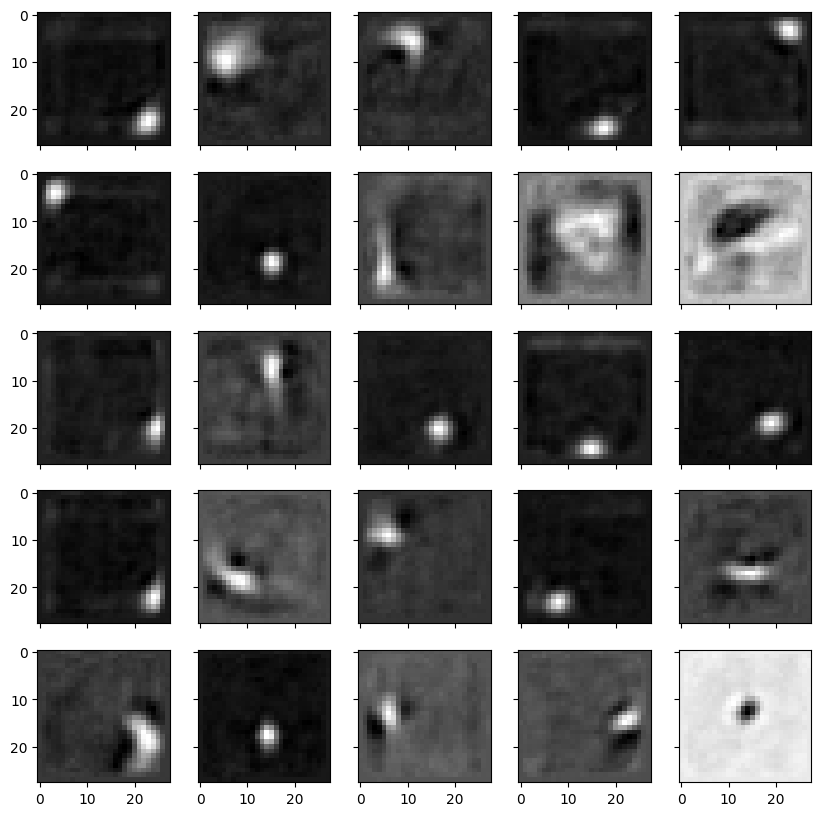

In [ ]:
plot_layer_receptive_fields(learned_weights_12_product.T)

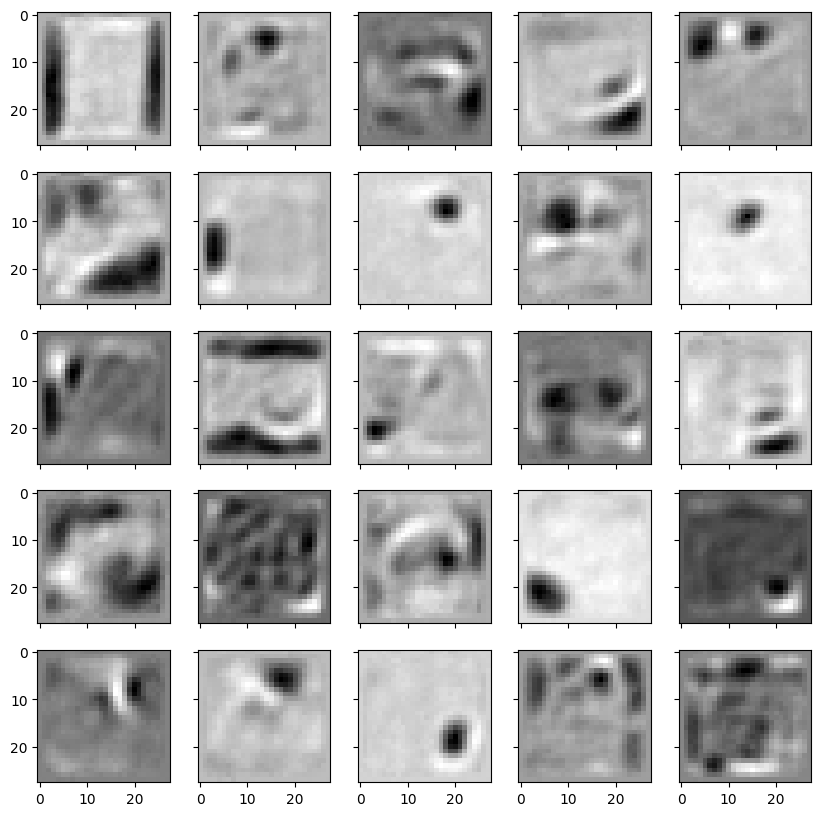

In [ ]:
plot_layer_receptive_fields(learned_weights_23_product.T)

## Clustering internal representations

In [ ]:
hidden_repr_layer_1, hidden_repr_layer_2, hidden_repr_layer_3 = get_all_layer_repr(data_train)

In [ ]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)

In [ ]:
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)

In [ ]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

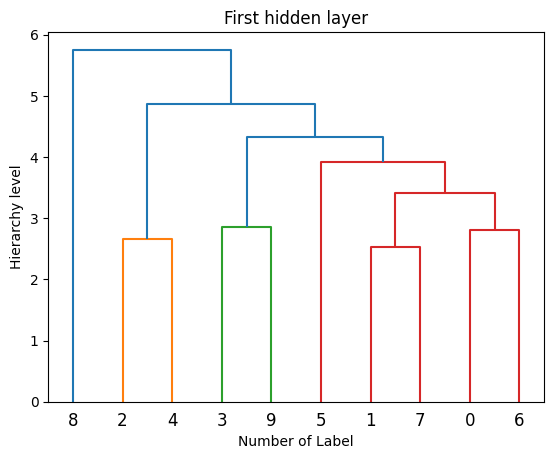

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

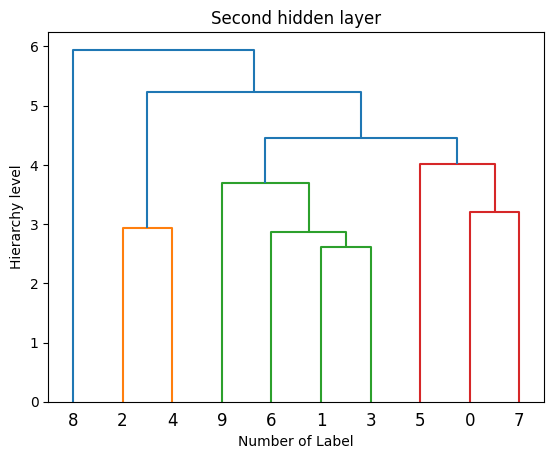

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

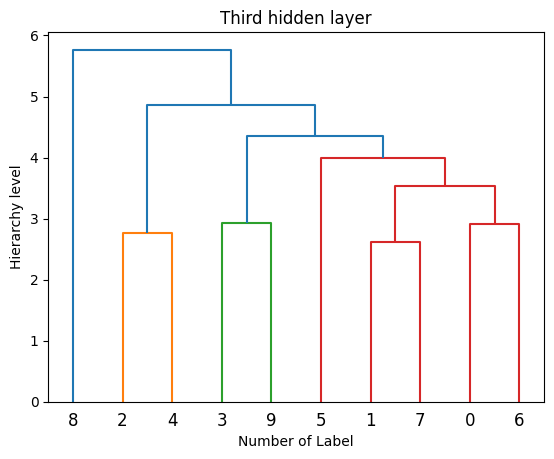

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

### Analysis of Dendrograms by ploting images

- As we can see in the previous section, classes (2,4), (6,9), (1,3) and (7, (1,3)) are put in the same cluster by the internal representations of all three layers of the DBN model. We now visualize the class pairs to investigate more and see if the images with similar shapes have indeed similar internal representations.

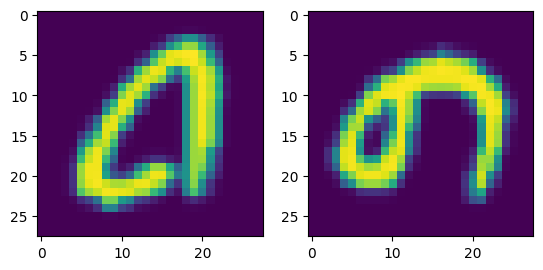

In [ ]:
plot_pair(data_train, labels_train, 2, 4)

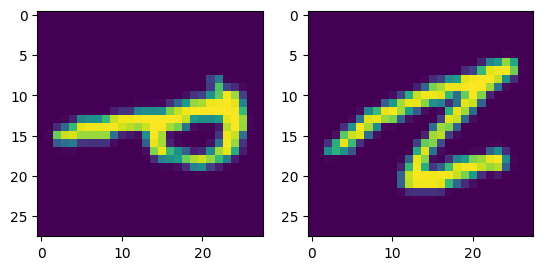

In [ ]:
plot_pair(data_train, labels_train, 1, 7, n_try = 10)


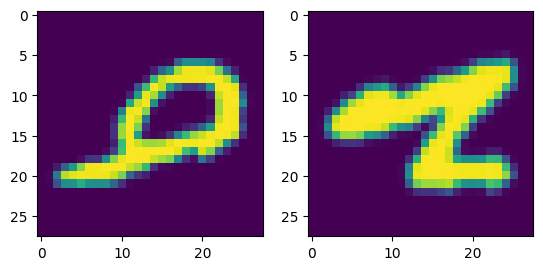

In [ ]:
plot_pair(data_train, labels_train, 3, 7, n_try = 16)

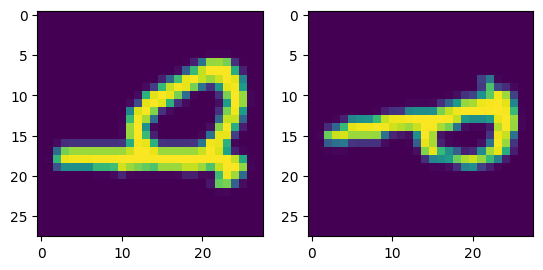

In [ ]:
plot_pair(data_train, labels_train, 3, 1, n_try = 10)

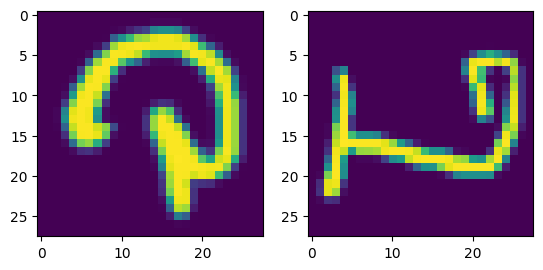

In [ ]:
plot_pair(data_train, labels_train, 6, 9, n_try = 10)

## Training perceptrons (readout layers)

In [ ]:
linear1, linear2, linear3 = get_linear_models(dbn_emnist)

In [ ]:
%%time
print('Train perceptron, attached to hidden layer 1')
train(linear1, hidden_repr_layer_1)

Train perceptron, attached to hidden layer 1
epoch :   1/1500, loss = 2.2981
epoch : 101/1500, loss = 1.0547
epoch : 201/1500, loss = 0.8341
epoch : 301/1500, loss = 0.7360
epoch : 401/1500, loss = 0.6769
epoch : 501/1500, loss = 0.6360
epoch : 601/1500, loss = 0.6052
epoch : 701/1500, loss = 0.5809
epoch : 801/1500, loss = 0.5609
epoch : 901/1500, loss = 0.5440
epoch : 1001/1500, loss = 0.5295
epoch : 1101/1500, loss = 0.5167
epoch : 1201/1500, loss = 0.5054
epoch : 1301/1500, loss = 0.4953
epoch : 1401/1500, loss = 0.4861
CPU times: user 3.27 s, sys: 66.8 ms, total: 3.34 s
Wall time: 3.43 s


In [ ]:
%%time
print('Train perceptron, attached to hidden layer 2')
train(linear2, hidden_repr_layer_2)

Train perceptron, attached to hidden layer 2
epoch :   1/1500, loss = 2.3488
epoch : 101/1500, loss = 1.0438
epoch : 201/1500, loss = 0.8216
epoch : 301/1500, loss = 0.7246
epoch : 401/1500, loss = 0.6668
epoch : 501/1500, loss = 0.6272
epoch : 601/1500, loss = 0.5975
epoch : 701/1500, loss = 0.5741
epoch : 801/1500, loss = 0.5549
epoch : 901/1500, loss = 0.5388
epoch : 1001/1500, loss = 0.5248
epoch : 1101/1500, loss = 0.5127
epoch : 1201/1500, loss = 0.5018
epoch : 1301/1500, loss = 0.4921
epoch : 1401/1500, loss = 0.4833
CPU times: user 3.78 s, sys: 58.5 ms, total: 3.84 s
Wall time: 3.94 s


In [ ]:
%%time
print('Train perceptron, attached to hidden layer 3')
train(linear3, hidden_repr_layer_3)

Train perceptron, attached to hidden layer 3
epoch :   1/1500, loss = 2.3266
epoch : 101/1500, loss = 1.0163
epoch : 201/1500, loss = 0.7859
epoch : 301/1500, loss = 0.6850
epoch : 401/1500, loss = 0.6246
epoch : 501/1500, loss = 0.5828
epoch : 601/1500, loss = 0.5516
epoch : 701/1500, loss = 0.5268
epoch : 801/1500, loss = 0.5065
epoch : 901/1500, loss = 0.4895
epoch : 1001/1500, loss = 0.4748
epoch : 1101/1500, loss = 0.4619
epoch : 1201/1500, loss = 0.4506
epoch : 1301/1500, loss = 0.4404
epoch : 1401/1500, loss = 0.4312
CPU times: user 4.87 s, sys: 52.1 ms, total: 4.93 s
Wall time: 5.05 s


In [ ]:
hidden_repr_layer_1_test, hidden_repr_layer_2_test, hidden_repr_layer_3_test = get_all_layer_repr(data_test)

In [ ]:
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [ ]:
acc1 = compute_accuracy(predictions_test1, labels_test)
acc2 = compute_accuracy(predictions_test2, labels_test)
acc3 = compute_accuracy(predictions_test3, labels_test)

print("Accuracy of perceptron attached to hidden layer 1:", acc1)
print("Accuracy of perceptron attached to hidden layer 2:", acc2)
print("Accuracy of perceptron attached to hidden layer 3:", acc3)

Accuracy of perceptron attached to hidden layer 1: 0.858625054359436
Accuracy of perceptron attached to hidden layer 2: 0.8592500686645508
Accuracy of perceptron attached to hidden layer 3: 0.8753750324249268


## Train Feedforward model
- We choose the FFNN architecture accordingly with the chosen DBN structure. Therefore, the three hidden layers of FFNN model contain (400, 500, 800) neurons respectively
- For performance comparison, training time of FFNN model should be comparable with that for deep belief network model.

In [ ]:
ffnn = Feedforward(400, 500, 800).to(device)

In [ ]:
%%time
train(ffnn, data_train.reshape((-1, 784)), epochs=1500)

epoch :   1/1500, loss = 2.3022
epoch : 101/1500, loss = 2.2111
epoch : 201/1500, loss = 1.4225
epoch : 301/1500, loss = 0.8871
epoch : 401/1500, loss = 0.7346
epoch : 501/1500, loss = 0.6552
epoch : 601/1500, loss = 0.5980
epoch : 701/1500, loss = 0.5749
epoch : 801/1500, loss = 0.5274
epoch : 901/1500, loss = 0.4889
epoch : 1001/1500, loss = 0.4562
epoch : 1101/1500, loss = 0.4255
epoch : 1201/1500, loss = 0.3960
epoch : 1301/1500, loss = 0.3688
epoch : 1401/1500, loss = 0.3454
CPU times: user 1min 9s, sys: 49.3 s, total: 1min 59s
Wall time: 1min 59s


In [ ]:
torch.save(ffnn, 'ffnn.pt')

In [ ]:
ffnn = torch.load('ffnn.pt')
ffnn.eval()

Feedforward(
  (first_hidden): Linear(in_features=784, out_features=400, bias=True)
  (second_hidden): Linear(in_features=400, out_features=500, bias=True)
  (third_hidden): Linear(in_features=500, out_features=800, bias=True)
  (output): Linear(in_features=800, out_features=10, bias=True)
)

In [ ]:
predictions_ffnn = ffnn(data_test.reshape((-1, 784)))

In [ ]:
acc_ffnn = compute_accuracy(predictions_ffnn, labels_test)
print("Accuracy of the FFNN:", acc_ffnn)

Accuracy of the FFNN: 0.8517500162124634


Compare FFNN with readout performance

In [ ]:
acc = {'perceptron_layer_1': compute_accuracy(predictions_test1, labels_test),
    'perceptron_layer_2': compute_accuracy(predictions_test2, labels_test),
    'perceptron_layer_3': compute_accuracy(predictions_test3, labels_test),
    'feedforward': compute_accuracy(predictions_ffnn, labels_test)}

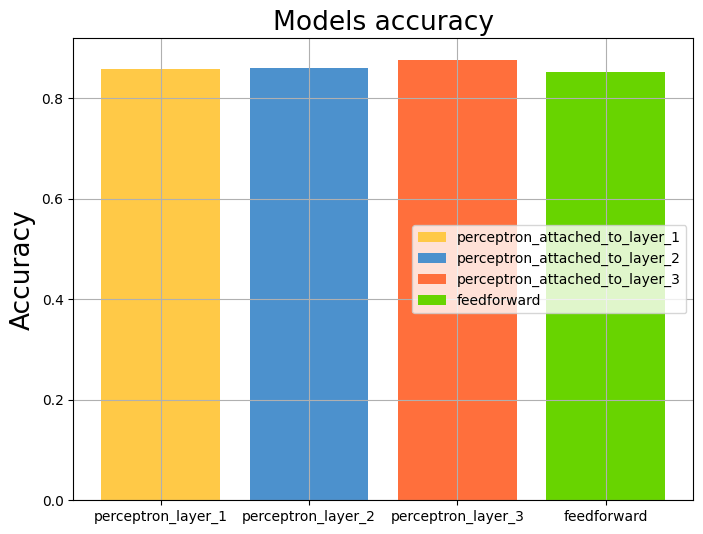

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.bar(acc.keys(), acc.values())

colors = ['#FFC947', '#4C91CD', '#FF6F3C', '#68D400']  # Add more colors if needed

bars = ax.bar(acc.keys(), acc.values(), color=colors)

ax.legend(bars, ['perceptron_attached_to_layer_1',
                 'perceptron_attached_to_layer_2',
                 'perceptron_attached_to_layer_3',
                 'feedforward'], loc= 'center right')

ax.set_title('Models accuracy', fontsize = 19)
plt.ylabel('Accuracy', fontsize = 19)
ax.tick_params(axis = 'both', labelsize = 10)
plt.grid()

## Robustness to noise

- In this chapter, we analyze robustness of Deep Belief Network and Feed-Forward Neural Networks against random noise, added to the input images
- We assess models performance for two type of noise:
    - Random Gaussian noise
    - Salt and Pepper

### Visualization of different noise types

- Gaussian

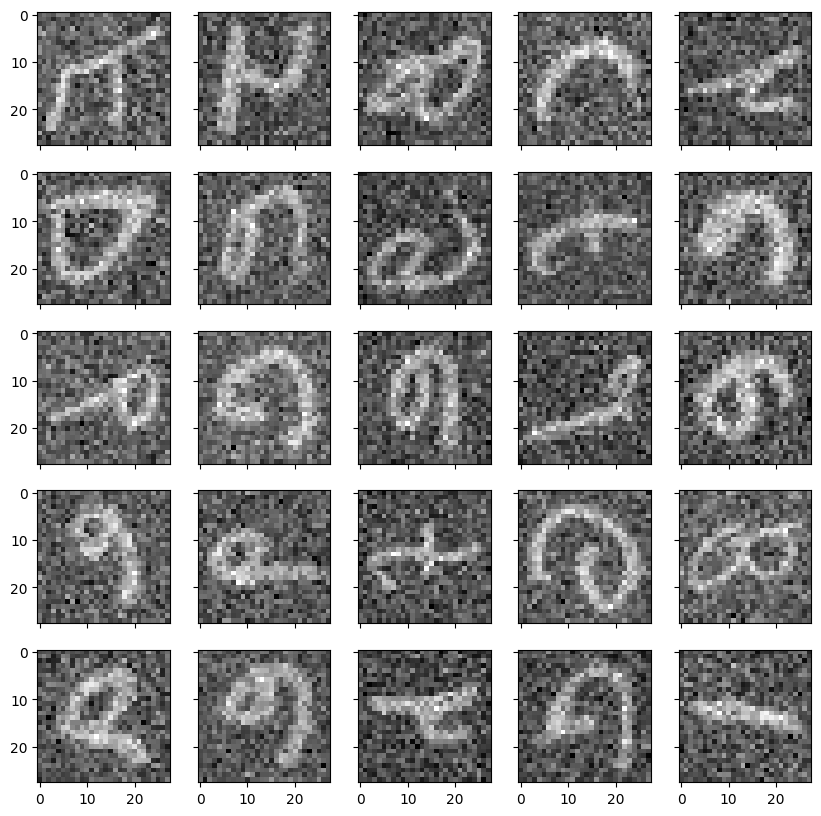

In [ ]:
plot_sample_data(inject_noise_gaussian(data_train, noise_level=0.3), num_subplots = 25)

- Salt and Pepper

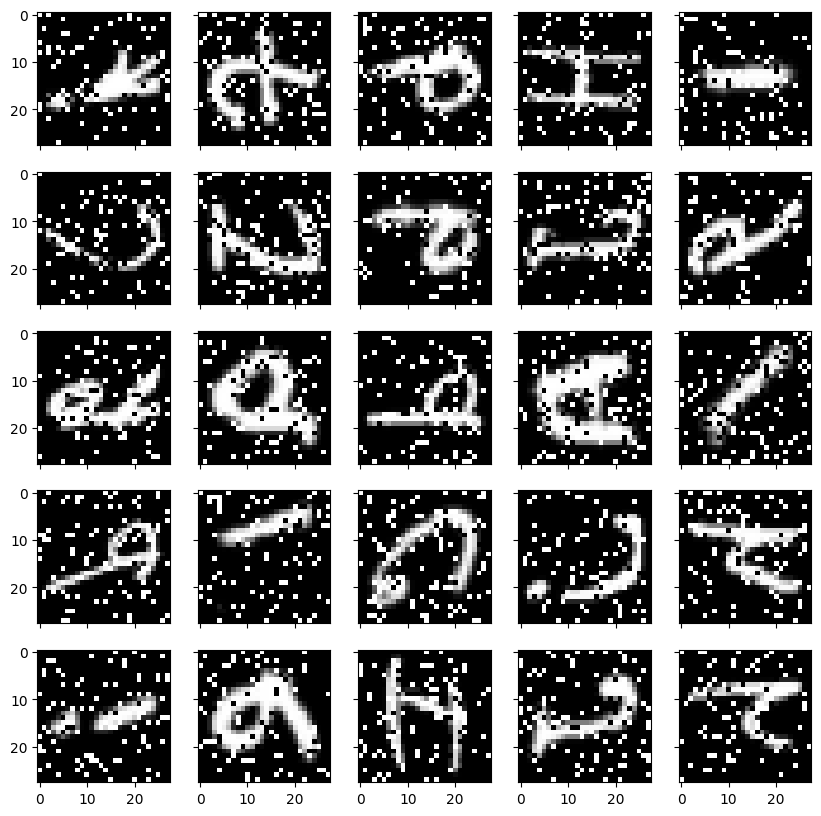

In [ ]:
plot_sample_data(inject_noise_sp(data_train, noise_level=0.2), num_subplots = 25)

Accuracy of different layers of DBN model and FFNN model on Gaussian noise

In [ ]:
acc_gaussian = get_accuracy_values_at_noise_level(inject_noise_gaussian,0.3);
print("Accuracy of H1 read-out: %.3f" % acc_gaussian[0])
print("Accuracy of H2 read-out: %.3f" % acc_gaussian[1])
print("Accuracy of H3 read-out: %.3f" % acc_gaussian[2])
print("Accuracy of FF network : %.3f" % acc_gaussian[3])

Accuracy of H1 read-out: 0.826
Accuracy of H2 read-out: 0.845
Accuracy of H3 read-out: 0.865
Accuracy of FF network : 0.824


Accuracy of different layers of DBN model and FFNN model on Salt and Pepper noise

In [ ]:
acc_sp = get_accuracy_values_at_noise_level(inject_noise_sp,0.2)
print("Accuracy of H1 read-out: %.3f" % acc_sp[0])
print("Accuracy of H2 read-out: %.3f" % acc_sp[1])
print("Accuracy of H3 read-out: %.3f" % acc_sp[2])
print("Accuracy of FF network : %.3f" % acc_sp[3])

Accuracy of H1 read-out: 0.691
Accuracy of H2 read-out: 0.721
Accuracy of H3 read-out: 0.758
Accuracy of FF network : 0.571


### Plotting noise robustness curves

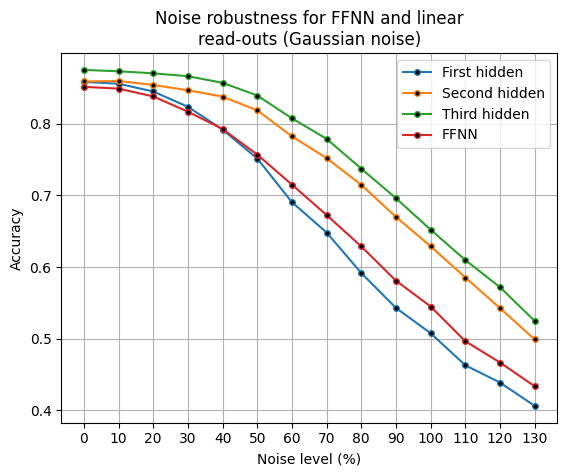

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves('gaussian', noise_levels)

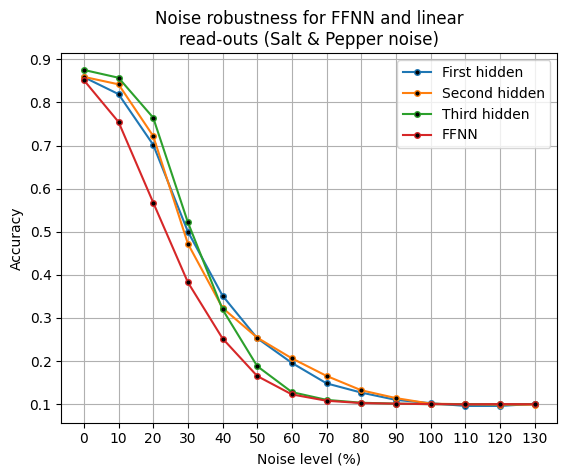

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves('sp', noise_levels)

## adversarial attacks

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

### Some samples of Adversarial attacks

attacked model: FFNN
The prediction of the model for this clean sample is 1.
The prediction of the model for the perturbed sample is 7.


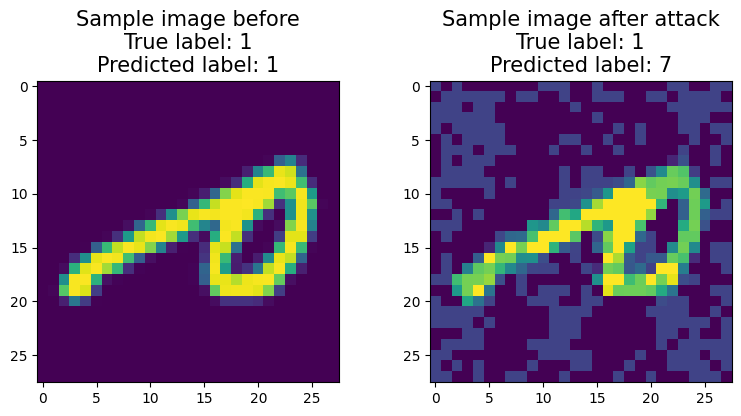

In [ ]:
attacked_model_ffnn = ffnn
print('attacked model: FFNN')
attack_demo(attacked_model_ffnn,index=1256, epsilon= 0.2)

attacked model: DBN with Readout
The prediction of the model for this clean sample is 1.
The prediction of the model for the perturbed sample is 3.


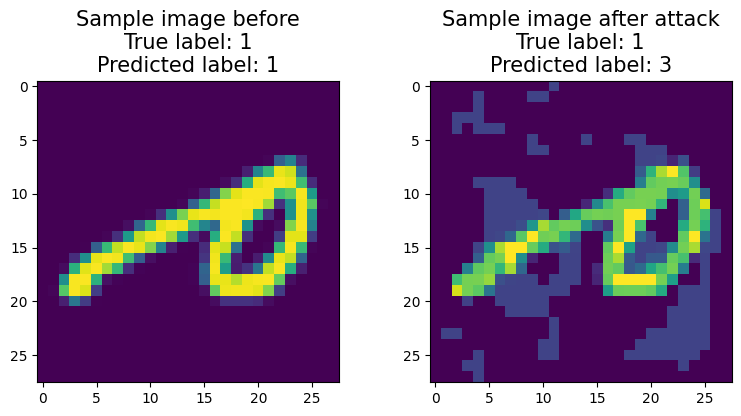

In [ ]:
attacked_model_dbn = dbn_with_readout
print('attacked model: DBN with Readout')
attack_demo(attacked_model_dbn,index=1256, epsilon= 0.2)

### Robustness to adversarial attacks

In [ ]:
test_loader = get_data_loader()

In [ ]:
ffnn = ffnn.to(device)
dbn_with_readout = dbn_with_readout.to(device)

In [ ]:
final_acc_ffnn = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)


Epsilon: 0.1
Test Accuracy: 20.89%



In [ ]:
final_acc_dbn = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)


Epsilon: 0.1
Test Accuracy: 65.61%




Here's the original sample:



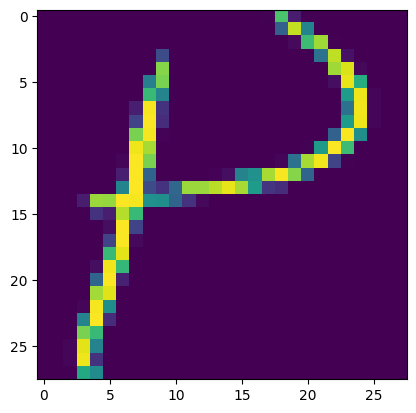


Here's a perturbed sample:



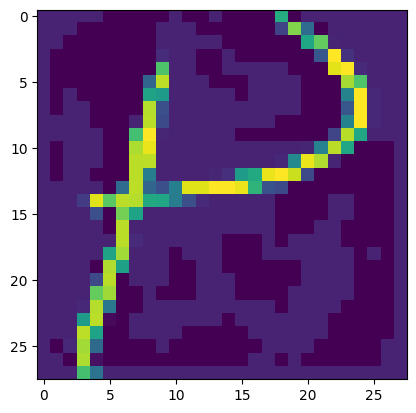


Here's what a 1-steps reconstructed sample looks like:



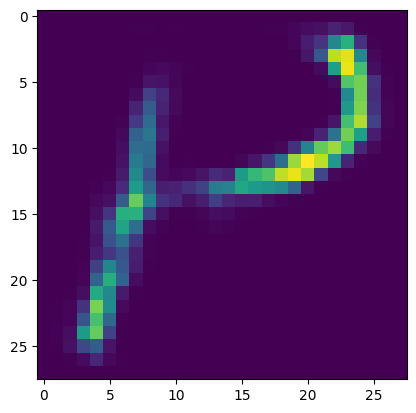


Epsilon: 0.1
Test Accuracy: 73.10%



In [ ]:
final_acc_dbn_ = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

### Effect of the noise parameter $\epsilon$

Now we compare the robustness of each model to adversarial attacks of different strengths

In [ ]:
epsilons = [0, 0.05, 0.10, 0.15, 0.20, 0.25]
accuracies_ffnn = test_epsilon_values_effect(ffnn, epsilons, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, epsilons, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, epsilons, n_steps=1)


Epsilon: 0
Test Accuracy: 85.18%


Epsilon: 0.05
Test Accuracy: 56.44%


Epsilon: 0.1
Test Accuracy: 20.89%


Epsilon: 0.15
Test Accuracy: 6.60%


Epsilon: 0.2
Test Accuracy: 1.41%


Epsilon: 0.25
Test Accuracy: 0.18%


Epsilon: 0
Test Accuracy: 87.54%


Epsilon: 0.05
Test Accuracy: 79.54%


Epsilon: 0.1
Test Accuracy: 65.61%


Epsilon: 0.15
Test Accuracy: 41.23%


Epsilon: 0.2
Test Accuracy: 20.34%


Epsilon: 0.25
Test Accuracy: 10.14%


Epsilon: 0
Test Accuracy: 87.44%


Epsilon: 0.05
Test Accuracy: 80.60%


Epsilon: 0.1
Test Accuracy: 73.10%


Epsilon: 0.15
Test Accuracy: 57.03%


Epsilon: 0.2
Test Accuracy: 33.35%


Epsilon: 0.25
Test Accuracy: 16.65%



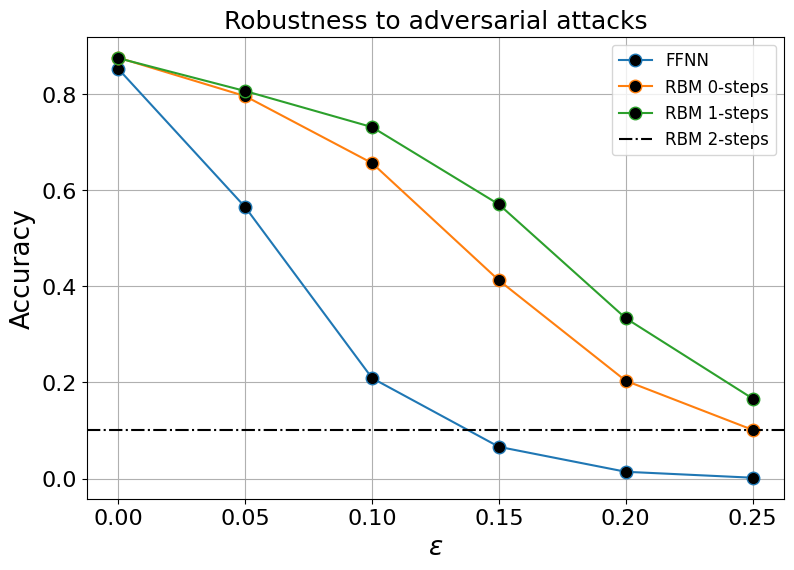

In [ ]:
accs = [
        accuracies_ffnn,
        accuracies_dbn_0,
        accuracies_dbn_1,
]

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharey=True)

for acc in accs:
    _ = ax.plot(
        epsilons[:], acc[:],
        marker = 'o',
        markerfacecolor = 'black',
        markersize = 9
    )

_ = ax.axhline(0.1, color='black', linestyle='-.')
_ = ax.set_xlabel("$\epsilon$", fontsize = 19)
_ = ax.set_ylabel("Accuracy", fontsize = 19)
_ = ax.set_title("Robustness to adversarial attacks", fontsize = 18)
plt.grid()
_ = ax.legend(["FFNN", "RBM 0-steps", "RBM 1-steps","chance level"], prop = {'size': 12})
ax.tick_params(axis = 'both', labelsize = 16)

## Confusion matrix analysis

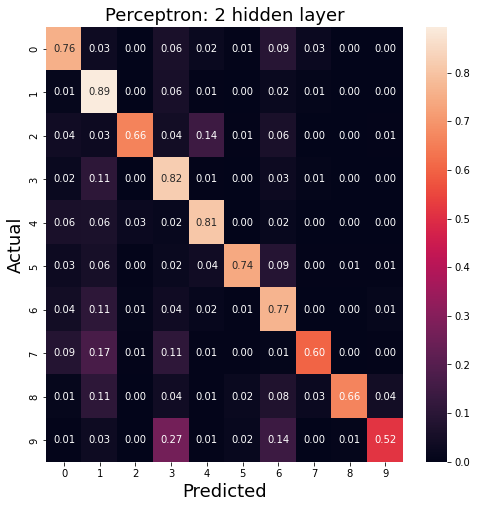

In [ ]:
plot_perc_conf_matrix(
    dbn_model = model_deep,
    n_layer = 2,
    targets = targets_test
)

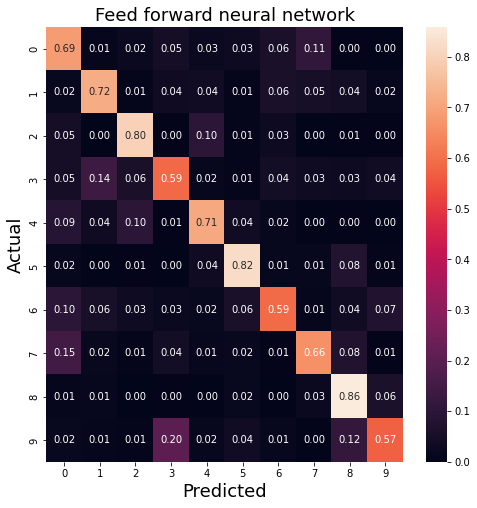

In [ ]:
plot_ffnn_confusion_matrix(
    ffnn_model = ffnn,
    data = data_test,
    targets = targets_test
)